# ML : Bike Sharing Dataset
+ Based on Bike Sharing dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
+ This notebook is based upon the hourly data file, i.e. hour.csv


### Problem Statement
Given the Bike Sharing dataset with hourly level information of bikes along with weather and other attributes,  solve the business problem of predicting bike demand for a given date time.

## Import required packages

In [44]:
# data manipulation 
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from tqdm import tqdm

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


# Sklearn model selection
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_val_score
# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import random
# Make results reproducible
random.seed(42)

#setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sns.set_style('whitegrid')
sns.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Dataset

In [2]:
hour_df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


## Preprocessing
+ Standarize column names
+ Typecast attributes
+ Encode Categoricals using One Hot Encoding

### Standarize Column Names

In [4]:
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

### Typecast Attributes

In [5]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

In [6]:
hour_df.head(3)

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32



### Encode Categoricals (One Hot Encoding)

In [16]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the one hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

## Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1],test_size=0.20, random_state=42)

X_train.reset_index(inplace=True)
y_train = y_train.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X_train.shape,y_train.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(13903, 15)(13903, 2)
Testing set::(3476, 15)


In [18]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

Though we have transformed all categoricals into their one-hot encodings, ordinal attributes such as hour, weekday, and so on do not require such encoding.

In [19]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X_train,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [20]:
feature_df_list = [X_train[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))


Shape::(13903, 19)


In [21]:
train_df_new.head(3)

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.20,0.55,0.2239,11,6,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.52,0.42,0.1045,18,2,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.46,1.00,0.2239,3,3,12,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
X_train = train_df_new


In [23]:
y_train= y_train.total_count.values.reshape(-1,1)
y_train=y_train.ravel()

In [24]:
#while we are here prepare the test data  like  the train data, for future use
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(3476, 19)


In [25]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
y_test=y_test.ravel()

# Machine Learning

### Metrics

Mean square error
\begin{equation}
MSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}
\end{equation}



\begin{equation}
R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}
\end{equation}
In the case of R^2, values closer to 0 are indicative of poor fitting models.


### Model selection:

- __Regression:__ The target variable is a quantity.
- __Small dataset:__ Less than 100K samples.
- __Few features should be important:__ The correlation matrix indicates that a few features contain the information to predict the target variable.

This characteristic makes the following methods most promising: Ridge Regression, Support Vector Regression, Ensemble Regressor, Random Forest Regressor.

Let us see the performance of these models in the following without any tuning yet:

In [29]:

table = PrettyTable()
table.field_names = ["Model", "datasetname", "MSE", "MAE","R^2 score"]

def evaluate(xx, yy,dataset,model):
    y_pred = model.predict(xx)
    mse = mean_squared_error( yy,y_pred)
    mae = mean_absolute_error(yy,y_pred)
    r2score = model.score(xx, yy)    
    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'), format(r2score, '.2f')])
    


CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 60.3 µs


In [30]:
%%time
models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    BaggingRegressor(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    NuSVR(gamma='auto'),
    RandomForestRegressor( random_state=42, n_estimators=300)
]

for model in models:
    model.fit(X_train, y_train) 
    evaluate(X_train, y_train,'training',model) #on the training set
print(table)
table.clear_rows() 

print("\n")
print("==== Let us evaluate the model on test set===")
for model in models:
    evaluate(X_test, y_test,'validation',model) #on the test/validation set  
print(table)


+-----------------------+-------------+----------+--------+-----------+
|         Model         | datasetname |   MSE    |  MAE   | R^2 score |
+-----------------------+-------------+----------+--------+-----------+
|      SGDRegressor     |   training  | 22575.20 | 120.77 |    0.32   |
|         Lasso         |   training  | 19986.21 | 105.81 |    0.40   |
|       ElasticNet      |   training  | 24764.29 | 116.98 |    0.25   |
|         Ridge         |   training  | 19983.74 | 105.86 |    0.40   |
|          SVR          |   training  | 22267.29 | 101.65 |    0.33   |
|          SVR          |   training  | 14622.71 | 72.51  |    0.56   |
|    BaggingRegressor   |   training  |  353.80  | 10.75  |    0.99   |
|    BaggingRegressor   |   training  | 11598.58 | 69.46  |    0.65   |
|         NuSVR         |   training  | 14779.30 | 80.41  |    0.55   |
| RandomForestRegressor |   training  |  251.99  |  9.50  |    0.99   |
+-----------------------+-------------+----------+--------+-----

RF seems to be most promising. Let us dig a bit more on RF model 

## Random Forest model

- with hyperparameter and crossvalidation

In [50]:
'''
param_grid = {"criterion": ["mae"],
              "min_samples_split": [10, 20, 40], #minimum number of samples required to split an internal node
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [10,20, 40],
              "max_leaf_nodes": [100, 500, 800],
              }
              
'''
param_grid = {"criterion": ["mae"],
              "min_samples_split": [2,4,6], #minimum number of samples required to split an internal node
              "min_samples_leaf": [1,5],
              
              }


In [51]:

rf=RandomForestRegressor( random_state=42)

In [52]:
grid_cv_rf = GridSearchCV(rf, param_grid, n_jobs=-1,cv=5,verbose=50)

In [53]:
%%time
grid_cv_rf.fit(X_train,y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   57

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mae'], 'min_samples_

In [54]:
#metrics on train data
print("R-Squared::{}".format(grid_cv_rf.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_rf.best_params_))

R-Squared::0.9327664944150883
Best Hyperparameters::
{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [55]:
param_df = pd.DataFrame(data=grid_cv_rf.cv_results_)
param_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.553122,0.332938,0.014418,0.000677,mae,1,2,"{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 2}",0.936992,0.925103,0.935329,0.937449,0.928960,0.932766,0.004890,1
1,28.457365,0.397863,0.012813,0.000482,mae,1,4,"{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 4}",0.936680,0.926967,0.934078,0.936394,0.929278,0.932679,0.003898,2
2,28.336460,0.227807,0.012458,0.000562,mae,1,6,"{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 6}",0.935652,0.925934,0.933447,0.935544,0.929058,0.931927,0.003832,3
3,27.169266,0.221663,0.010548,0.000218,mae,5,2,"{'criterion': 'mae', 'min_samples_leaf': 5, 'min_samples_split': 2}",0.933791,0.911512,0.930962,0.931546,0.921398,0.925842,0.008332,4
4,25.366842,3.599186,0.009654,0.001586,mae,5,4,"{'criterion': 'mae', 'min_samples_leaf': 5, 'min_samples_split': 4}",0.933791,0.911512,0.930962,0.931546,0.921398,0.925842,0.008332,4


In [57]:
%%time
#metrics on validation data
r2scores = cross_val_score(grid_cv_rf.best_estimator_, X_test, y_test, cv=5)
mse_scores = cross_val_score(grid_cv_rf.best_estimator_, X_test, y_test, cv=5,scoring='neg_mean_absolute_error')
print("avg R-squared::{}".format(np.mean(r2scores)))
print("MAE::{}".format(np.mean(mse_scores)))

avg R-squared::0.8922636211557166
MAE::-37.267429690730175
CPU times: user 13.5 s, sys: 4.92 ms, total: 13.5 s
Wall time: 13.5 s


It looks like our default RF regressor was pretty good

### Feature importance

In [60]:
tuned_rf = grid_cv_rf.best_estimator_

In [100]:
#features= hour_df.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
features=list(X_test.columns.values)
features

['temp',
 'humidity',
 'windspeed',
 'hour',
 'weekday',
 'month',
 'year',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'is_holiday_0',
 'is_holiday_1',
 'weather_condition_1',
 'weather_condition_2',
 'weather_condition_3',
 'weather_condition_4',
 'is_workingday_0',
 'is_workingday_1']

In [101]:
importances = tuned_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in tuned_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [102]:
## Print the feature ranking
print("Feature ranking:")
print(X_test.shape[1])
for f in range(X_test.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
19
1. feature hour (0.526248)
2. feature temp (0.131615)
3. feature year (0.057722)
4. feature humidity (0.056898)
5. feature is_workingday_0 (0.036920)
6. feature month (0.036606)
7. feature windspeed (0.035807)
8. feature weekday (0.032343)
9. feature is_workingday_1 (0.028488)
10. feature weather_condition_3 (0.014790)
11. feature season_1 (0.012270)
12. feature season_4 (0.008287)
13. feature weather_condition_1 (0.006320)
14. feature weather_condition_2 (0.004877)
15. feature season_2 (0.003347)
16. feature season_3 (0.003084)
17. feature is_holiday_0 (0.002263)
18. feature is_holiday_1 (0.002110)
19. feature weather_condition_4 (0.000005)


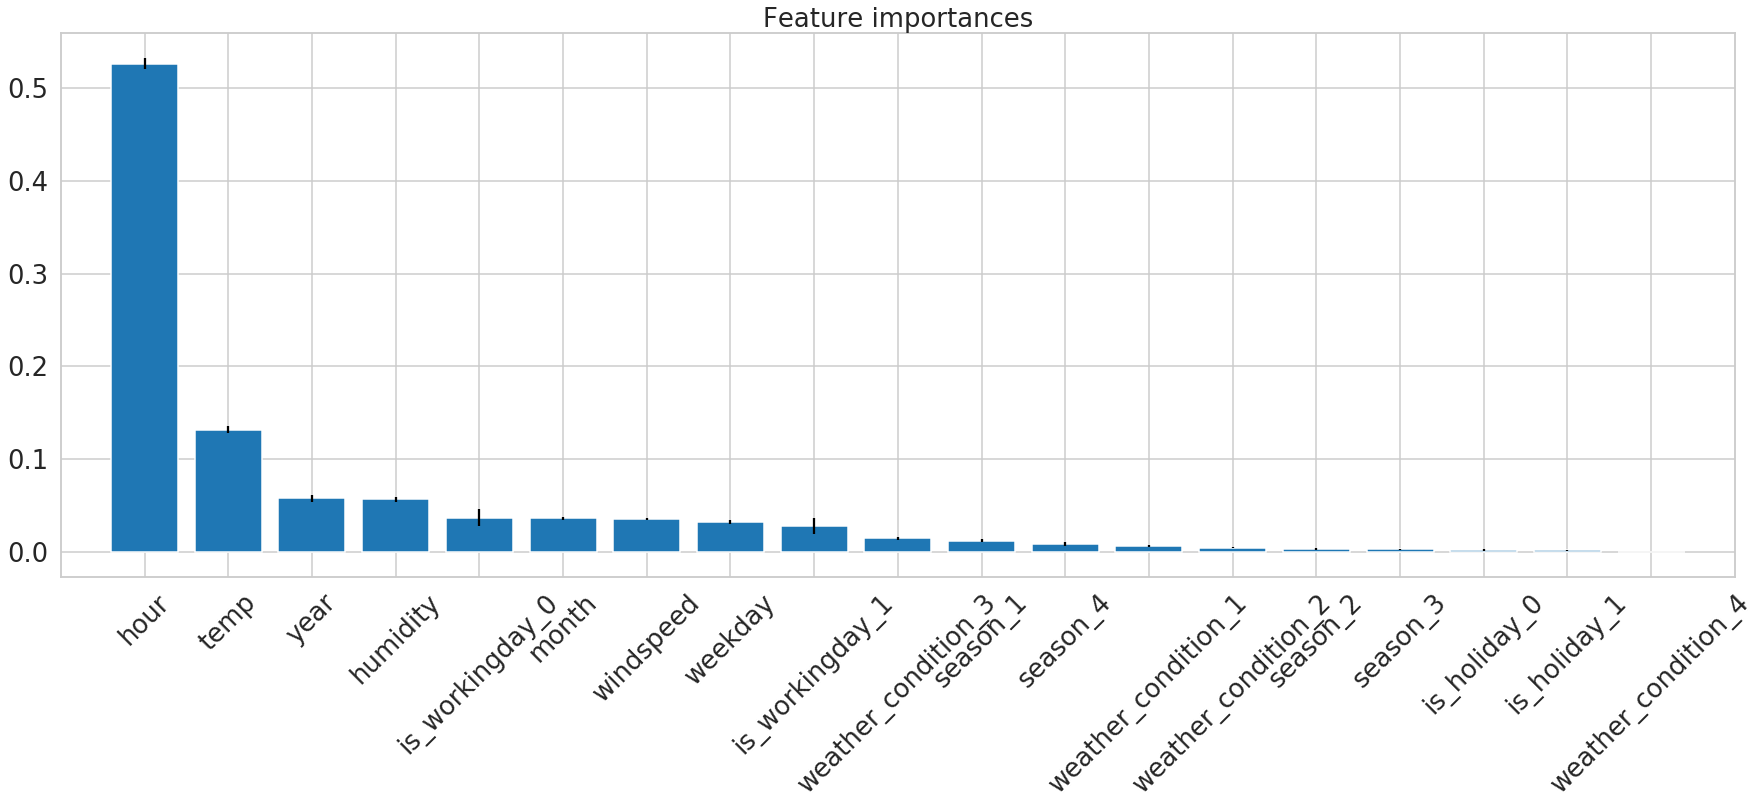

In [106]:
# Plot the feature importances of the random forest
#plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[i] for i in indices],rotation=45)
plt.xlim([-1, X_test.shape[1]])
plt.show()

These are the main features and its relative importance in our developed model. From our EDA, we saw that hour of the day and temperature plays significant role, which is kind of reflected here as well.